----
Apply word2vec to SPAM | HAM MESSAGES dataset
-----

Overview:

1. Prepocessing training data
1. Setup word2vec model in TensorFlow
1. Train on the data a bit
1. Visualize the result


In [77]:
reset -fs

In [78]:
import collections
import math
import os
from pprint import pprint
import random
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE
from textblob import TextBlob, Word
import re


%matplotlib inline  

In [79]:
tf.__version__

'1.0.0'

----
Step 1: Load data
----

In [80]:
with open('smsspamcollection/SMSSpamCollection.txt') as f:
    text = f.read()

In [81]:
splitted_text_toline = text.splitlines()
y = []
X = []
for line in splitted_text_toline:
    line = line.split('\t')
    y.append(line[0])
    X.append(line[1])

In [82]:
en_blob = TextBlob(text)
translated_text = en_blob.translate(to='en')

In [83]:
corrected_text=[]
for line in translated_text.split('\n'):
    # TextBlob is providing correct method
    corrected_text.append(TextBlob(line).correct())

In [84]:
lemma_text = []
for line in corrected_text:
    lemma_text.append(Word(line).lemmatize())

In [85]:
singularized_text = []
for line in lemma_text:
    singularized_text.append(" ".join(line.words.singularize()))

In [86]:
y = []
X = []
for line in singularized_text:
    line = re.sub(r'(?<=^ham)\s|(?<=^spasm)\s', '\t', line)
    line = line.split('\t')
    
#     print(line, len(line))
    if len(line) == 2:
        y.append(line[0].replace('spasm', 'spam'))
        X.append(line[1])

In [87]:
vocabulary = TextBlob(" ".join(X)).words

In [89]:
# Let's have a peek at the head
vocab_head = vocabulary[:5]
print(vocab_head)

['To', 'until', 'during', 'point', 'crazy']


In [90]:
# Let's have a peek at the tail
vocabulary[-5:]

WordList(['It', 'true', 'to', 'it', 'name'])

Notice: None of the words are capitalized and there is no punctuation.

Preprocessing is an art. It depends on your raw data and how you plan to use your final data. You might want to encode ngrams, instead of just splitting all items into unigrams.

-----
Step 2: Build the dictionary 
-----

In [91]:
vocabulary_size = 50_000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
#         print(len(dictionary))
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [92]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)

In [93]:
len(vocabulary)

88042

data - list of codes (integers from 0 to vocabulary_size-1).
    This is the original text but words are replaced by their codes

count - map of words(strings) to count of occurrences

dictionary - map of words(strings) to their codes(integers)

reverse_dictionary - maps codes(integers) to words(strings)

In [94]:
del vocabulary # Reduce memory by getting rid of the "heavy" list of strings

In [95]:
data[:5] # An index of each word (as it appears in order) to its rank. Therefore we don't have reference the string

[18, 482, 1092, 434, 894]

In [96]:
dictionary['the'] # word: rank

6

In [97]:
reverse_dictionary[42] # rank: word

'You'

In [98]:
print('Most common words:') 
print(*count[:5], sep="\n")

Most common words:
['UNK', 0]
('to', 2241)
('I', 2084)
('you', 1913)
('a', 1521)


In [99]:
print('Most least words:')
print(*count[-5:], sep="\n")

Most least words:
('2.50', 1)
('£750', 1)
('087187272008', 1)
('NOW1', 1)
('itching', 1)


----
Step 3: Function to generate a training batch for the skip-gram model.
-----

In [100]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [101]:
batch, labels = generate_batch(batch_size=8, 
                               num_skips=2, 
                               skip_window=1)

In [102]:
print(vocab_head)

['To', 'until', 'during', 'point', 'crazy']


In [103]:
# Example of self-supervised
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

482 until -> 1092 during
482 until -> 18 To
1092 during -> 482 until
1092 during -> 434 point
434 point -> 894 crazy
434 point -> 1092 during
894 crazy -> 2281 Available
894 crazy -> 434 point


----
Step 4: Build and train a skip-gram model.
-----

In [104]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [105]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
        # Explanation of the meaning of NCE loss:
        #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
        loss = tf.reduce_mean(
          tf.nn.nce_loss(weights=nce_weights,
                         biases=nce_biases,
                         labels=train_labels,
                         inputs=embed,
                         num_sampled=num_sampled,
                         num_classes=vocabulary_size))

        # Construct the SGD optimizer using a learning rate of 1.0.
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

        # Compute the cosine similarity between minibatch examples and all embeddings.
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_dataset)
        similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)

        # Add variable initializer.
        init = tf.global_variables_initializer()

----
Step 5: Begin training.
-----

In [106]:
num_steps = 2_001 #1 #2_001 #100_001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        try:
            batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        except:
            print('Cannot generate this batch:', batch_size, num_skips, skip_window, step)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2_000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10_000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                nearest = [int(i/10) for i in nearest]
                print(nearest)
                print(reverse_dictionary[nearest[0]])
                log_str = "Nearest to '%s':" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  269.0831604
[2940, 1611, 1196, 4549, 2453, 2627, 3914, 1379]
DeliveredTomorrow
Nearest to ''m': DeliveredTomorrow, Arm, seriously, AVENT, shortage, Convey, Shampain, POLY,
[72, 951, 3050, 2948, 1173, 2590, 1006, 4616]
only
Nearest to 'so': only, confirm, 69888, MATE, P, Friday, fact, 69876,
[3926, 743, 4038, 3769, 4532, 466, 1444, 2208]
Rakhesh
Nearest to 'only': Rakhesh, Still, solved, build, babyjontet, remember, Back, midnight,
[3118, 1542, 51, 4487, 3191, 1843, 2824, 4133]
PLAY
Nearest to 'have': PLAY, lead, when, 69988, July, Person, 2MORO, priscilla,
[267, 4140, 1353, 1764, 2542, 1354, 3928, 3425]
minute
Nearest to 'not': minute, Untamed, key, Older, Thing, normal, wrote, quiet,
[1832, 3684, 4918, 1840, 3802, 2188, 3288, 145]
silent
Nearest to 'about': silent, ACTION, still.maybe, antus, nd, REALLY, lay, they,
[1649, 582, 1787, 2935, 1230, 3643, 3058, 1755]
High
Nearest to 'in': High, mob, supply, challenge, admirer, utf, everywhere, daddy,


-----
Step 6: Visualize the embeddings.
----

We'll use t-sne.

[t-sne](https://lvdmaaten.github.io/tsne/) is a cool way to visualize of high-dimensional datasets by reducing the number dimensions.

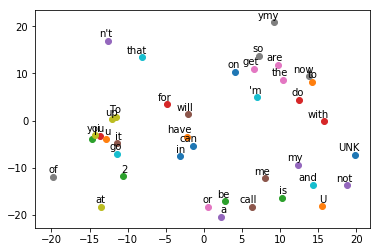

In [107]:
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

n_words_to_visualize = 40

for i, label in enumerate(labels[:n_words_to_visualize]):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

----
Reflective Visualization
----

The distance of 40 words is displayed in 2D showed the relativity between each word vs its surrounding words


------

Let's render and save more samples.

In [108]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

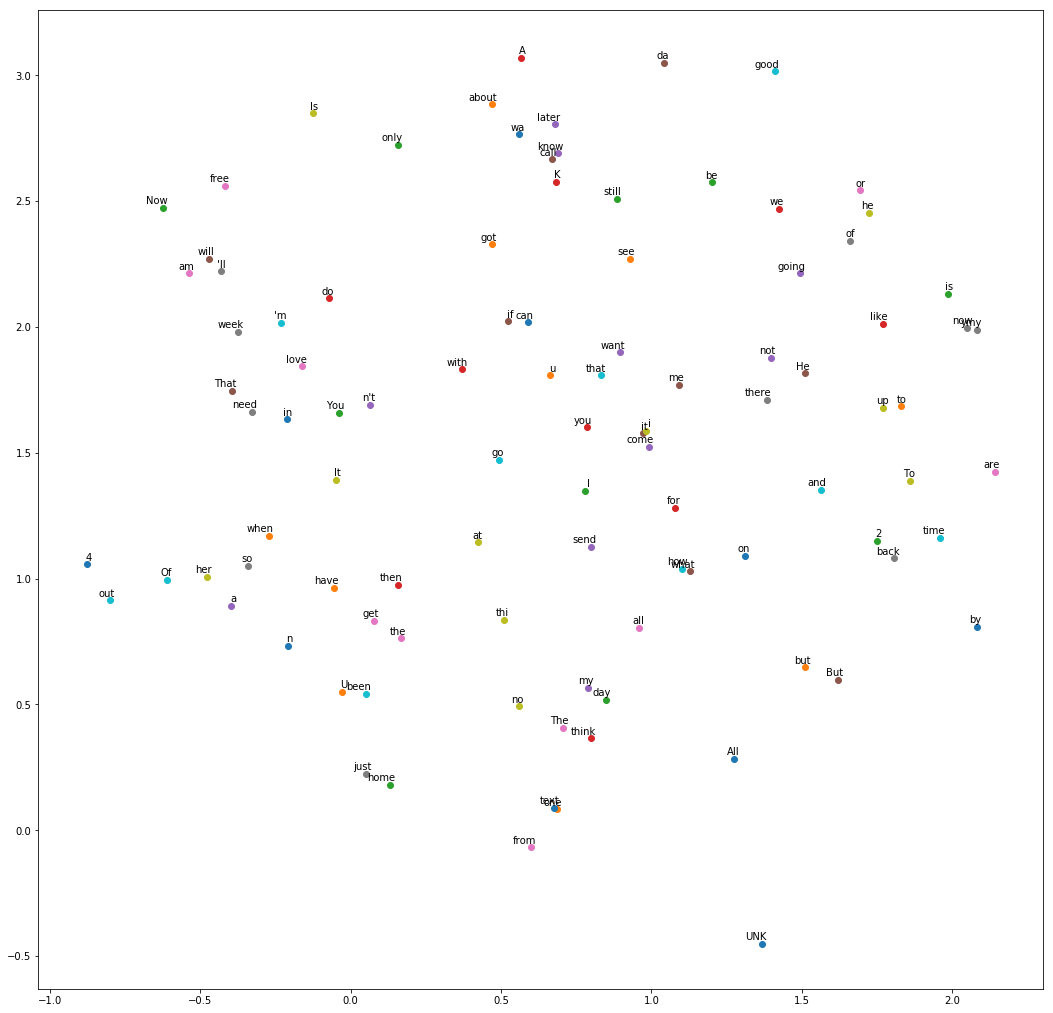

In [111]:
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

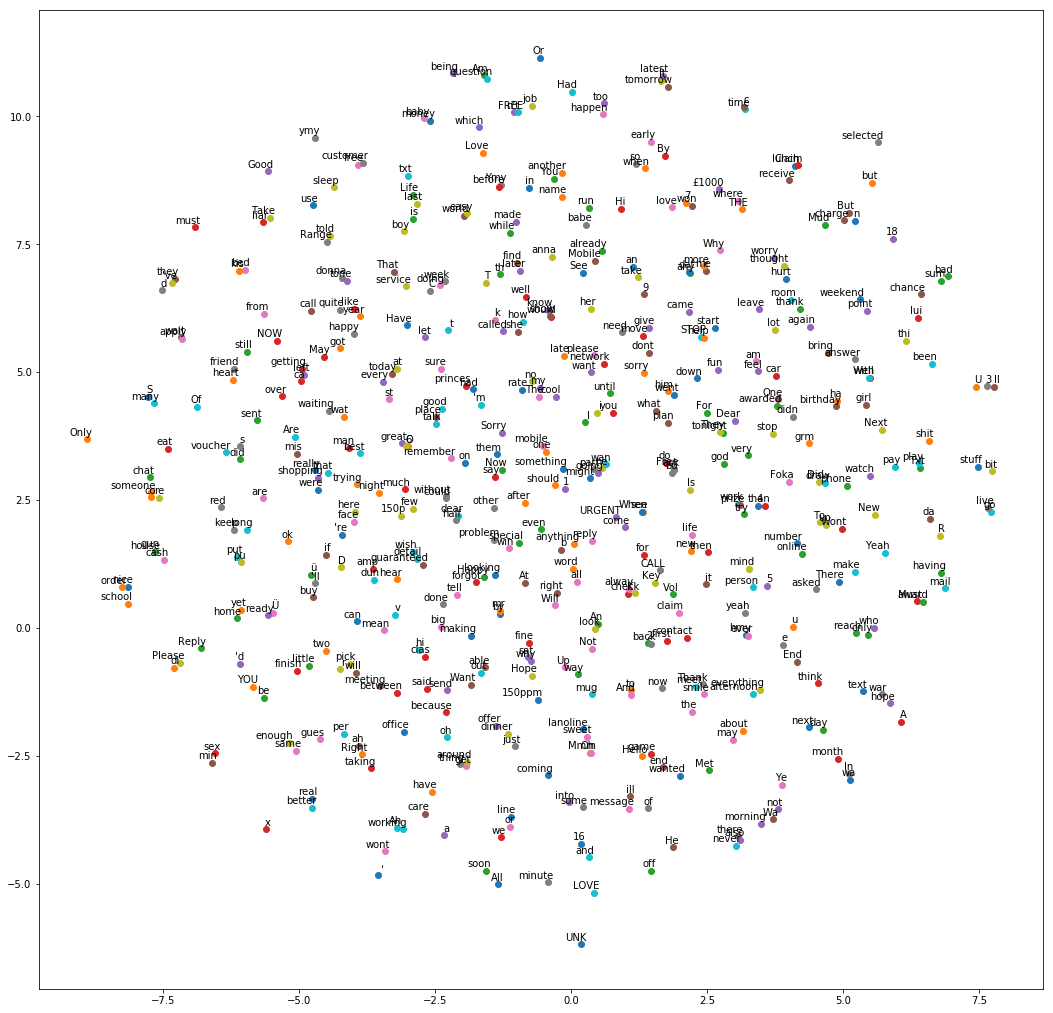

In [109]:
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

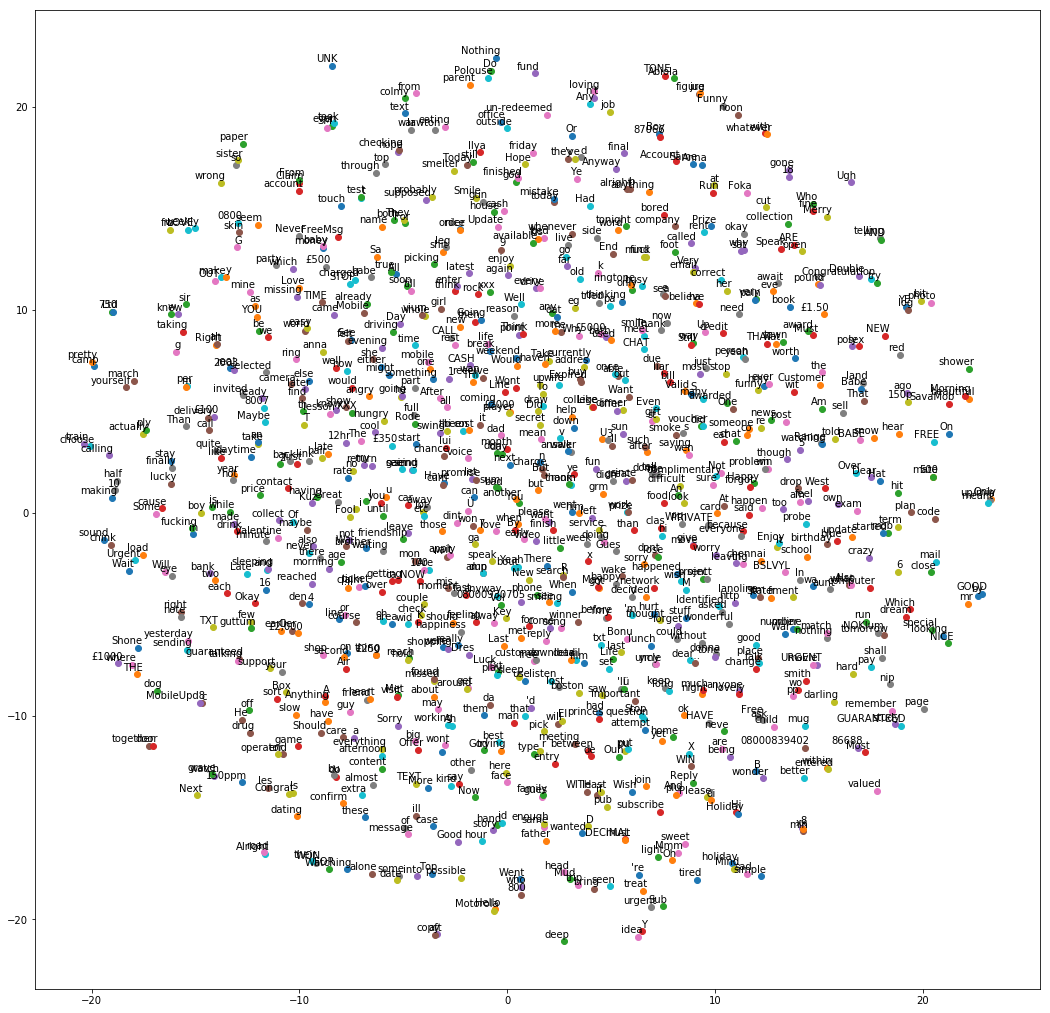

In [110]:
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
plot_only = 1000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

<br>
<br> 
<br>

----